In [1]:
import pandas as pd
import glob
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your folder containing CSV files within Google Drive
# IMPORTANT: Make sure your 'twittertrolls' folder is in the root of 'My Drive'
# or adjust the path accordingly, e.g., '/content/drive/My Drive/my_data_folder/twittertrolls/'
folder_path = '/content/drive/My Drive/big_data/raw csv/'

# Get a list of all CSV files in the specified folder
all_csv_files = glob.glob(folder_path + "*.csv")

# Initialize an empty list to store individual DataFrames
li = []

# Loop through each CSV file, read it, and append to the list
for filename in all_csv_files:
    try:
        df_chunk = pd.read_csv(filename, low_memory=False)
        li.append(df_chunk)
        print(f"Successfully loaded {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

# Concatenate all DataFrames in the list into a single DataFrame
if li:
    merged_df = pd.concat(li, axis=0, ignore_index=True)
    print(f"\nSuccessfully merged {len(li)} CSV files. Total rows: {merged_df.shape[0]}, Total columns: {merged_df.shape[1]}")

    # Save the merged DataFrame to a new CSV file in Google Drive
    output_filename = '/content/drive/My Drive/big_data/merged_twitter_trolls.csv'
    merged_df.to_csv(output_filename, index=False)
    print(f"Merged data saved to '{output_filename}'")
else:
    print("No CSV files found or loaded successfully. Please check the folder_path and file contents.")


Mounted at /content/drive
Successfully loaded /content/drive/My Drive/big_data/raw csv/IRAhandle_tweets_7.csv
Successfully loaded /content/drive/My Drive/big_data/raw csv/IRAhandle_tweets_12.csv


KeyboardInterrupt: 

In [2]:
# Import necessary libraries
import pandas as pd
import re

# Define the path to your original CSV
csv_file_path = '/content/drive/My Drive/big_data/merged_twitter_trolls.csv'
output_parquet_file = '/content/drive/My Drive/big_data/russian_trolls.parquet'

try:
    # 1. Read the CSV file
    print("Reading CSV file...")
    df = pd.read_csv(csv_file_path, low_memory=False)
    initial_rows = df.shape[0]
    print(f"Dataset loaded. Initial rows: {initial_rows}")


    # 2. Save to Spark-Compatible Parquet
    print(f"Saving to {output_parquet_file}...")
    df.to_parquet(
        output_parquet_file,
        engine='pyarrow',
        compression='snappy',
        index=False,
        # These two options are key for Databricks/Spark compatibility
        allow_truncated_timestamps=True,
        version='1.0'
    )
    print("File saved")

except FileNotFoundError:
    print(f"Error: File not found at {csv_file_path}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Reading CSV file...


KeyboardInterrupt: 

In [3]:
# --- CELL 2: Load the Dataset ---
# Adjust path if necessary
file_path = '/content/drive/My Drive/big_data/russian_trolls.parquet'

try:
    print("Loading dataset...")
    df = pd.read_parquet(file_path)

    # Ensure date is datetime format
    df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')

    print("Dataset loaded.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

Loading dataset...
Dataset loaded.
Shape: (2946207, 21)


In [11]:
#
# ---------------------------------------------------------------------------------
# EDA Script for the FULL, PROCESSED Russian Troll Tweets Dataset
# ---------------------------------------------------------------------------------
#

#
# --- 1. Import Necessary Libraries ---
#
# (This section remains exactly the same)
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re


print("\n--- Initial Data Inspection ---")
print("Shape of the dataset (rows, columns):", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nColumn data types and non-null values:")
# Note how the dtypes are already optimized!
df.info()





--- Initial Data Inspection ---
Shape of the dataset (rows, columns): (2946207, 21)

First 5 rows of the dataset:
   external_author_id     author  \
0  890000000000000000  JOHAAJOTS   
1  890000000000000000  JOHAAJOTS   
2  890000000000000000  JOHAAJOTS   
3  890000000000000000  JOHAAJOTS   
4  890000000000000000  JOHAAJOTS   

                                             content         region language  \
0  #jobb According to Mad Max, no one is More “DE...  United States  English   
1  #jobb TRUMP EFFECT : July Job Numbers CRUSH Ex...  United States  English   
2  #jobb You Won’t Believe Who is Now Calling for...  United States  English   
3  #jobb Fake News Media Ignoring This! https://t...  United States  English   
4  #jobb WITCH HUNT : Russia Probe Includes Tenan...  United States  English   

         publish_date  harvested_date  following  followers  updates  ...  \
0 2017-08-05 11:41:00  8/5/2017 11:41       2960        669      400  ...   
1 2017-08-05 11:46:00  8/5/2017 1

In [16]:
print("--- DATA QUALITY AUDIT ---\n")

# 1. Basic Info and Dimensions
print(f"Dataset Shape: {df.shape}")
print("\nColumn Data Types:")
print(df.dtypes)

# 2. DateTime Conversion
# Ensuring dates are actual datetime objects for temporal analysis
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df['harvested_date'] = pd.to_datetime(df['harvested_date'], errors='coerce')

# 3. Missing Values Check
missing = df.isnull().sum()
print("\nMissing Values per Column:")
print(missing[missing > 0])

# 4. Duplicate Check (based on tweet_id)
duplicates = df.duplicated(subset=['tweet_id']).sum()
print(f"\nDuplicate Tweet IDs found: {duplicates}")

# 5. Date Range Check
print(f"\nDate Range: {df['publish_date'].min()} to {df['publish_date'].max()}")

--- DATA QUALITY AUDIT ---

Dataset Shape: (2946207, 21)

Column Data Types:
external_author_id            object
author                        object
content                       object
region                        object
language                      object
publish_date          datetime64[ns]
harvested_date        datetime64[ns]
following                      int64
followers                      int64
updates                        int64
post_type                     object
account_type                  object
retweet                        int64
account_category              object
new_june_2018                  int64
alt_external_id               object
tweet_id                       int64
article_url                   object
tco1_step1                    object
tco2_step1                    object
tco3_step1                    object
dtype: object

Missing Values per Column:
content             1
region           8818
post_type     1648625
tco1_step1     845971
tco2_step1    22

--- PART 1: TEMPORAL ANALYSIS ---



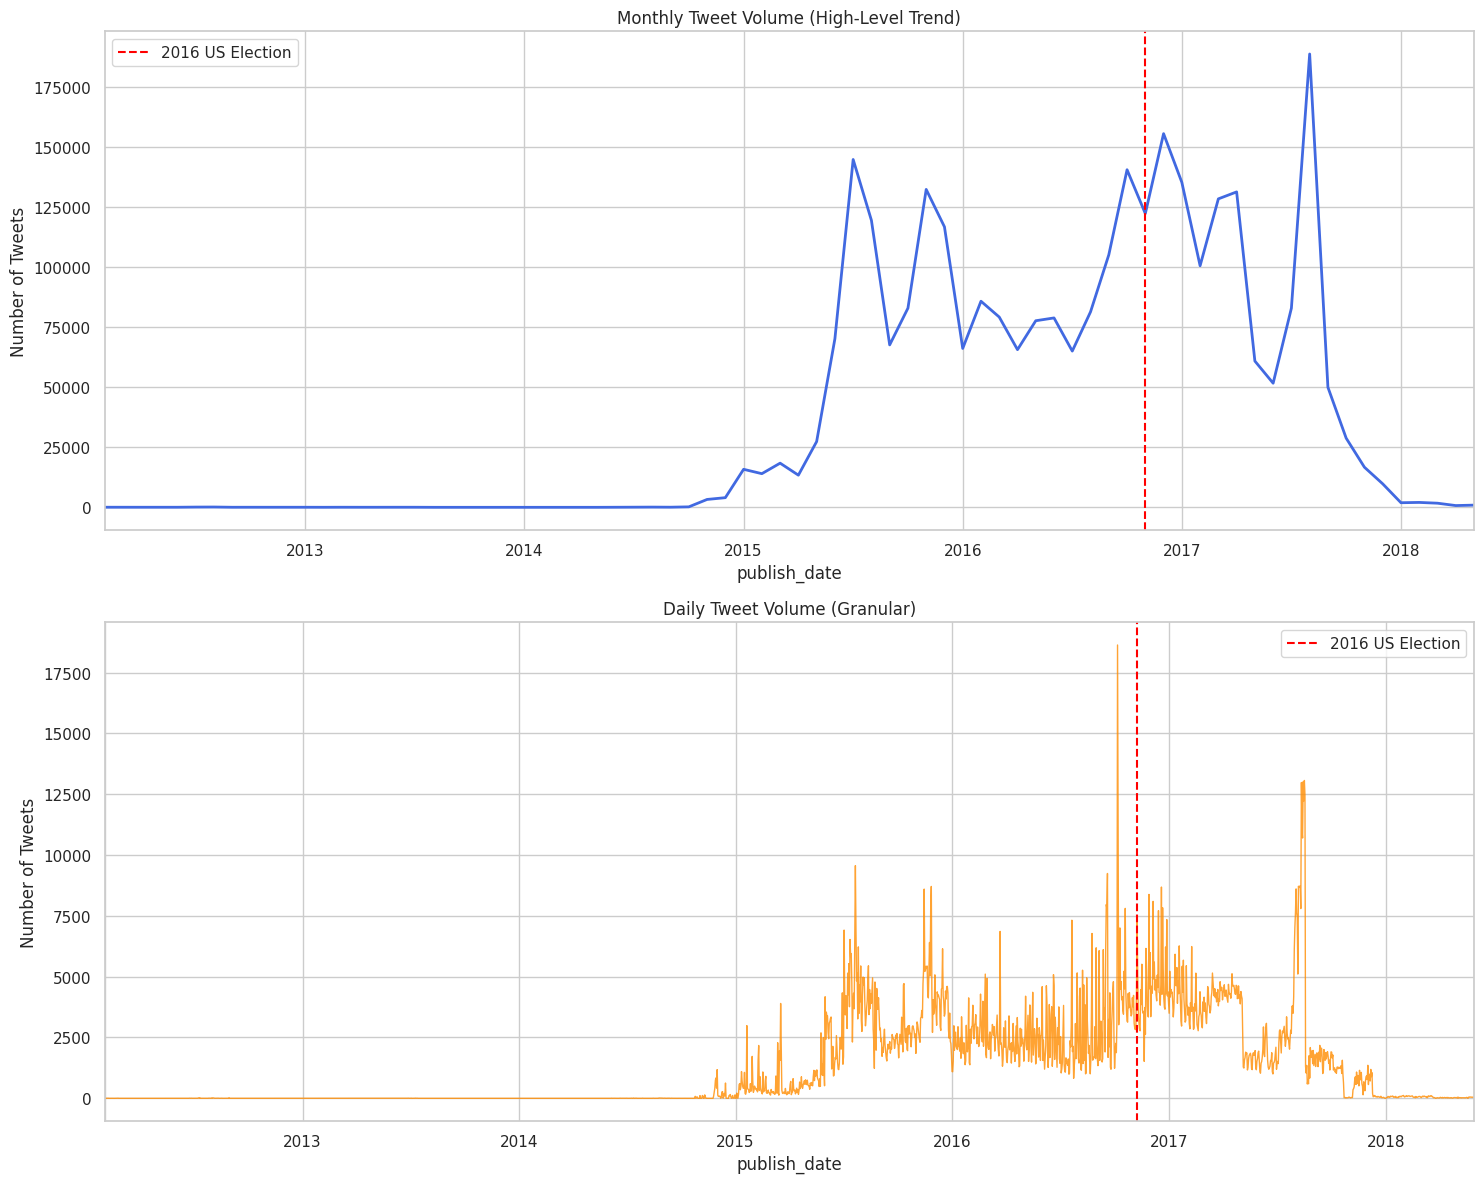

In [33]:
print("--- PART 1: TEMPORAL ANALYSIS ---\n")

# Set index to publish_date for resampling
time_df = df.set_index('publish_date').sort_index()

# Resample by Month ('ME' is month-end) and Day
monthly_counts = time_df.resample('ME').size()
daily_counts = time_df.resample('D').size()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Monthly Trend
monthly_counts.plot(ax=ax[0], color='royalblue', linewidth=2)
ax[0].set_title('Monthly Tweet Volume (High-Level Trend)')
ax[0].set_ylabel('Number of Tweets')
# Highlight 2016 Election (common in this dataset's analysis)
election_date = '2016-11-08'
ax[0].axvline(pd.to_datetime(election_date), color='red', linestyle='--', label='2016 US Election')
ax[0].legend()

# Daily Trend (Granular)
daily_counts.plot(ax=ax[1], color='darkorange', linewidth=1, alpha=0.8)
ax[1].set_title('Daily Tweet Volume (Granular)')
ax[1].set_ylabel('Number of Tweets')

# Highlight 2016 Election (common in this dataset's analysis)
election_date = '2016-11-08'
ax[1].axvline(pd.to_datetime(election_date), color='red', linestyle='--', label='2016 US Election')
ax[1].legend()

plt.tight_layout()
plt.show()

--- PART 2: ACTOR & CATEGORY ANALYSIS ---


/tmp/ipython-input-3109663288.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='account_category', data=df, order=df['account_category'].value_counts().index,


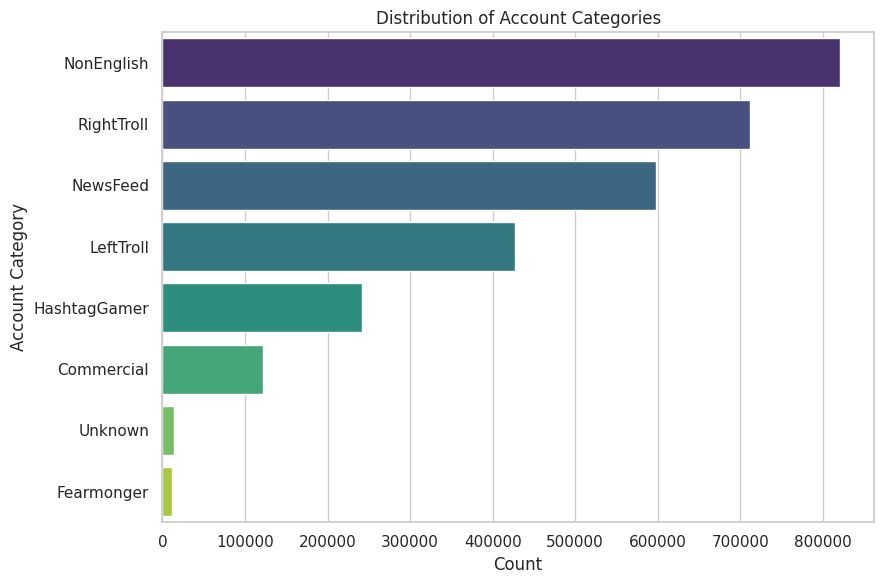

/tmp/ipython-input-3109663288.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions.values, y=top_regions.index, palette='magma')


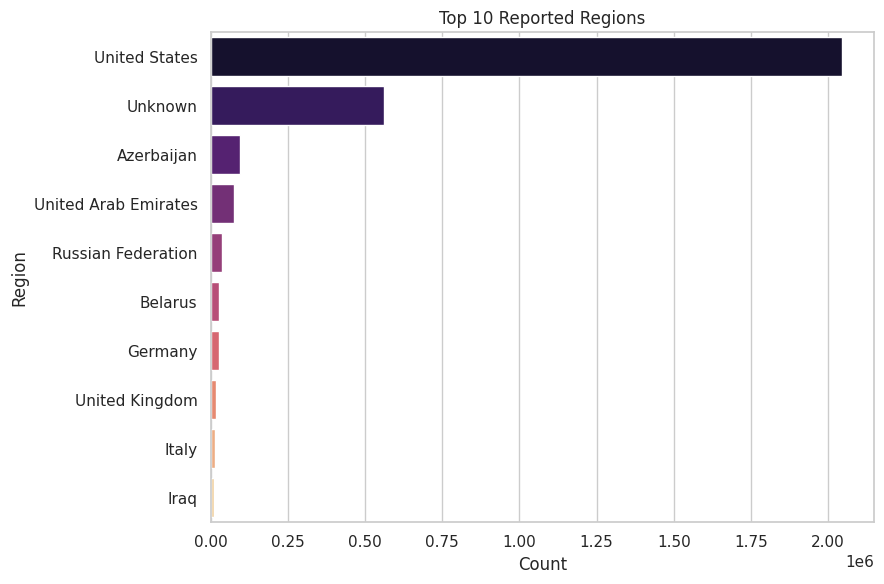

/tmp/ipython-input-3109663288.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_languages.index.astype(str), x=top_languages.values, palette='viridis')


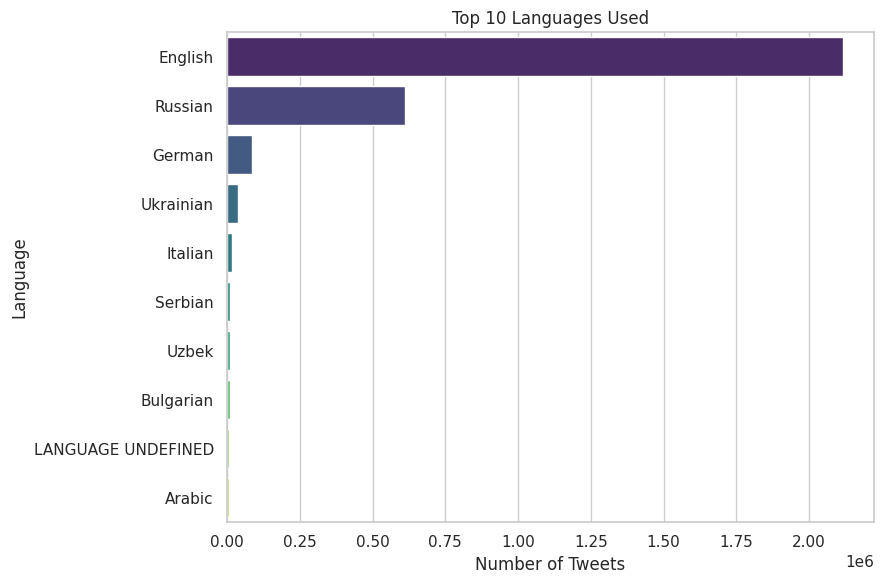

In [31]:
print("--- PART 2: ACTOR & CATEGORY ANALYSIS ---")

# 1. Account Category Distribution (Linvill and Warren coding)
plt.figure(figsize=(9, 6))
sns.countplot(y='account_category', data=df, order=df['account_category'].value_counts().index,
              palette='viridis')
plt.title('Distribution of Account Categories')
plt.xlabel('Count')
plt.ylabel('Account Category')
plt.tight_layout()
plt.show()

# 2. Region Distribution
plt.figure(figsize=(9, 6))
top_regions = df['region'].value_counts().head(10)
sns.barplot(x=top_regions.values, y=top_regions.index, palette='magma')
plt.title('Top 10 Reported Regions')
plt.xlabel('Count')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

# 3. Top Languages
plt.figure(figsize=(9, 6))
top_languages = df['language'].value_counts().nlargest(10)
sns.barplot(y=top_languages.index.astype(str), x=top_languages.values, palette='viridis')
plt.title('Top 10 Languages Used')
plt.xlabel('Number of Tweets')
plt.ylabel('Language')
plt.tight_layout()
plt.show()

--- PART 3: HASHTAG ANALYSIS  ---


/tmp/ipython-input-720955695.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Hashtag', data=hashtags_df, palette='cool')


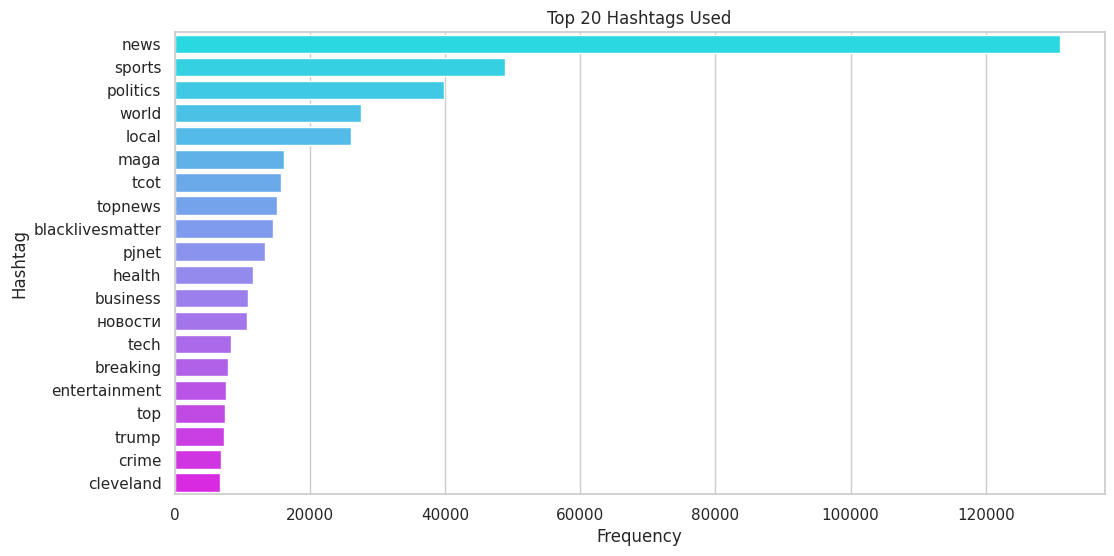

In [60]:
print("--- PART 3: HASHTAG ANALYSIS  ---")

# Simplified function dedicated to hashtags
def get_top_hashtags(text_series, top_n=20):
    all_hashtags = []
    for text in text_series.dropna():
        # Find all words that start with '#'
        # \w+ matches alphanumeric characters including underscores
        tags = re.findall(r"#(\w+)", str(text))

        # Convert to lowercase to ensure #News and #news are counted together
        tags = [tag.lower() for tag in tags]

        all_hashtags.extend(tags)

    return Counter(all_hashtags).most_common(top_n)

# 1. Calculate Top Hashtags
top_hashtags_list = get_top_hashtags(df['content'])
hashtags_df = pd.DataFrame(top_hashtags_list, columns=['Hashtag', 'Count'])

# 2. Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Hashtag', data=hashtags_df, palette='cool')
plt.title('Top 20 Hashtags Used')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()


[4.2] Generating plots for activity patterns by day of week and hour of day...


/tmp/ipython-input-2256520067.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='day_of_week', data=df, order=day_order, palette='cividis', ax=axes[0])
/tmp/ipython-input-2256520067.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='hour_of_day', data=df, palette='magma', ax=axes[1])


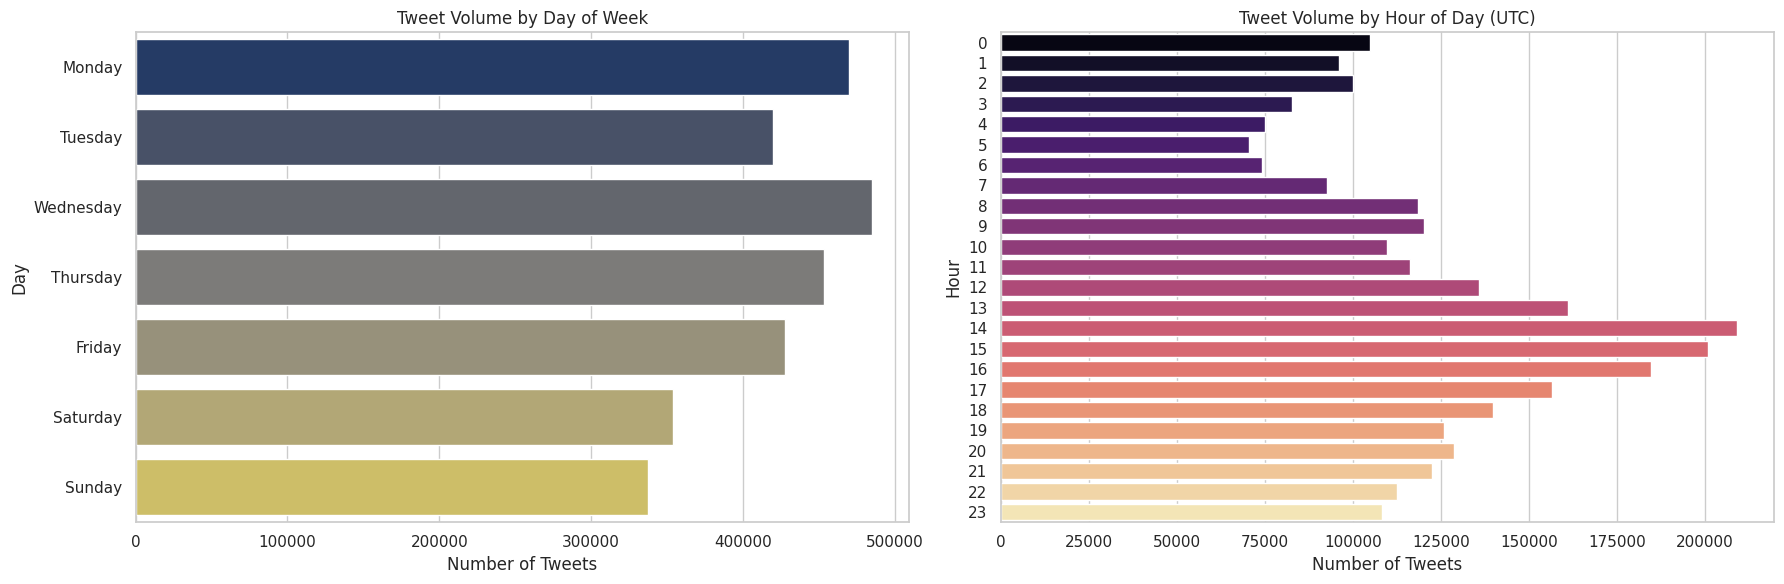

In [44]:
# 4.2: NEW - Activity Patterns by Day and Hour
print("\n[4.2] Generating plots for activity patterns by day of week and hour of day...")
df['day_of_week'] = df['publish_date'].dt.day_name()
df['hour_of_day'] = df['publish_date'].dt.hour
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Day of Week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(y='day_of_week', data=df, order=day_order, palette='cividis', ax=axes[0])
axes[0].set_title('Tweet Volume by Day of Week')
axes[0].set_xlabel('Number of Tweets')
axes[0].set_ylabel('Day')
# Hour of Day
sns.countplot(y='hour_of_day', data=df, palette='magma', ax=axes[1])
axes[1].set_title('Tweet Volume by Hour of Day (UTC)')
axes[1].set_xlabel('Number of Tweets')
axes[1].set_ylabel('Hour')
plt.tight_layout()
plt.show()


In [45]:
print("--- PREPARING FULL DATASET FOR ACTOR ANALYSIS ---\n")

# 1. Ensure dates are proper datetime objects
df['publish_date'] = pd.to_datetime(df['publish_date'])

# 2. Extract 'original_author' for the Amplifier analysis
# This pulls the username from tweets starting with "RT @username:"
# We use a regex that looks for the pattern and captures the name
print("Extracting original authors from retweets (this may take a moment)...")
df['original_author'] = df['content'].str.extract(r'RT @(\w+):')

# 3. Verify creation
print("Feature Engineering Complete.")
print(f"Total Retweets identified: {df['original_author'].notnull().sum()}")
display(df[['author', 'content', 'original_author']].head())

--- PREPARING FULL DATASET FOR ACTOR ANALYSIS ---

Extracting original authors from retweets (this may take a moment)...
Feature Engineering Complete.
Total Retweets identified: 13216


,author,content,original_author
0,JOHAAJOTS,"#jobb According to Mad Max, no one is More “DE...",NaN
1,JOHAAJOTS,#jobb TRUMP EFFECT : July Job Numbers CRUSH Ex...,NaN
2,JOHAAJOTS,#jobb You Won’t Believe Who is Now Calling for...,NaN
3,JOHAAJOTS,#jobb Fake News Media Ignoring This! https://t...,NaN
4,JOHAAJOTS,#jobb WITCH HUNT : Russia Probe Includes Tenan...,NaN


--- ACTOR CATEGORY: TIER 1 - THE WORKHORSES ---

(Accounts with the highest total tweet volume)

author
EXQUOTE            59174
SCREAMYMONKEY      44001
AMELIEBALDWIN      35261
WORLDNEWSPOLI      35155
TODAYPITTSBURGH    33602
SPECIALAFFAIR      32556
SEATTLE_POST       30793
FINDDIET           29038
KANSASDAILYNEWS    28806
ROOMOFRUMOR        28351
Name: count, dtype: int64


/tmp/ipython-input-2738190504.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_workhorses.values, y=top_workhorses.index, palette='viridis')


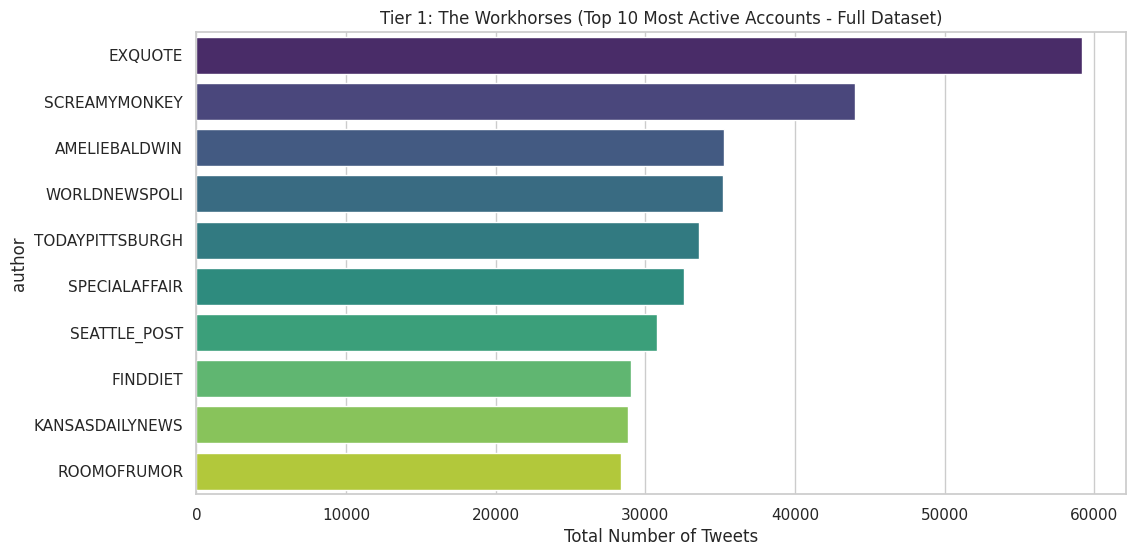

In [52]:
print("--- ACTOR CATEGORY: TIER 1 - THE WORKHORSES ---\n")
print("(Accounts with the highest total tweet volume)\n")

# 1. Identify Top 10 most active authors
top_workhorses = df['author'].value_counts().head(10)

print(top_workhorses)

# 2. Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=top_workhorses.values, y=top_workhorses.index, palette='viridis')
plt.title('Tier 1: The Workhorses (Top 10 Most Active Accounts - Full Dataset)')
plt.xlabel('Total Number of Tweets')
plt.show()

--- ACTOR CATEGORY: TIER 2 - THE BROADCASTERS ---

(Accounts with the highest maximum follower count)

author
NOVOSTIMSK        251276
TEN_GOP           145244
NOVOSTISPB        113638
KADIROVRUSSIA     110155
MAXDEMENTIEV      103197
LAVROVMUESLI       72720
JENN_ABRAMS        71022
PAMELA_MOORE13     70734
TODAYNYCITY        62088
ELEVEN_GOP         59100
Name: followers, dtype: int64


/tmp/ipython-input-1131601395.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_broadcasters.values, y=top_broadcasters.index, palette='plasma')


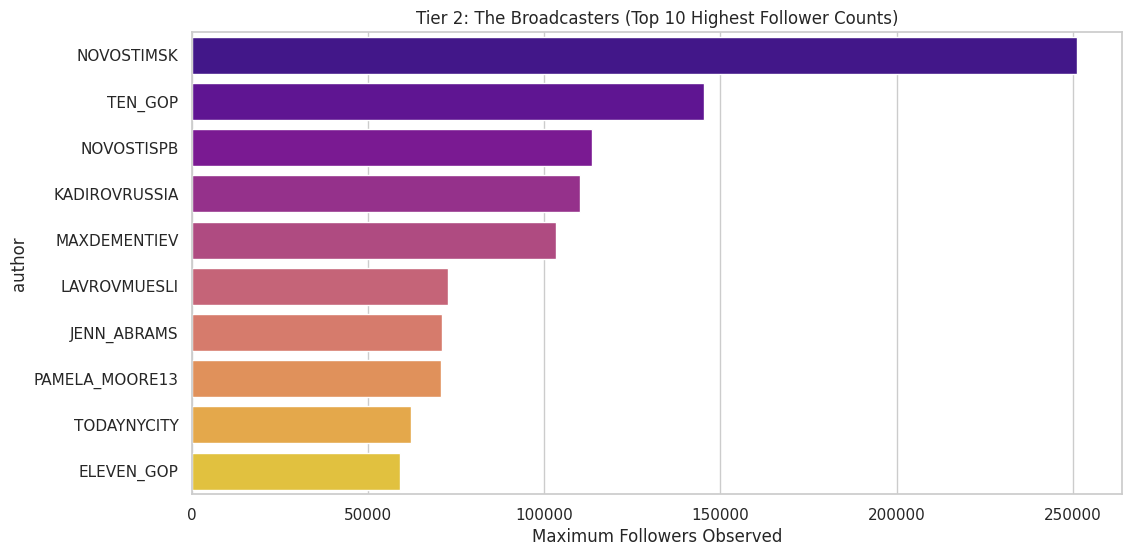

In [51]:
print("--- ACTOR CATEGORY: TIER 2 - THE BROADCASTERS ---\n")
print("(Accounts with the highest maximum follower count)\n")

# 1. Identify Top 10 authors by max followers
# We use max() because follower counts fluctuate over time
top_broadcasters = df.groupby('author')['followers'].max().sort_values(ascending=False).head(10)

print(top_broadcasters)

# 2. Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=top_broadcasters.values, y=top_broadcasters.index, palette='plasma')
plt.title('Tier 2: The Broadcasters (Top 10 Highest Follower Counts)')
plt.xlabel('Maximum Followers Observed')
plt.show()

--- ACTOR CATEGORY: TIER 3 - THE AMPLIFIERS ---

(External accounts most frequently retweeted by the dataset)

original_author
jstines3           254
2AFight            216
Shooters_Wife      208
dansch2002         146
gerfingerpoken     137
Network_Citizen    126
Fingersflying      108
mitchellvii         91
Stonewall_77        84
beny_benson         74
Name: count, dtype: int64


/tmp/ipython-input-2630466854.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_amplifiers.values, y=top_amplifiers.index, palette='magma')


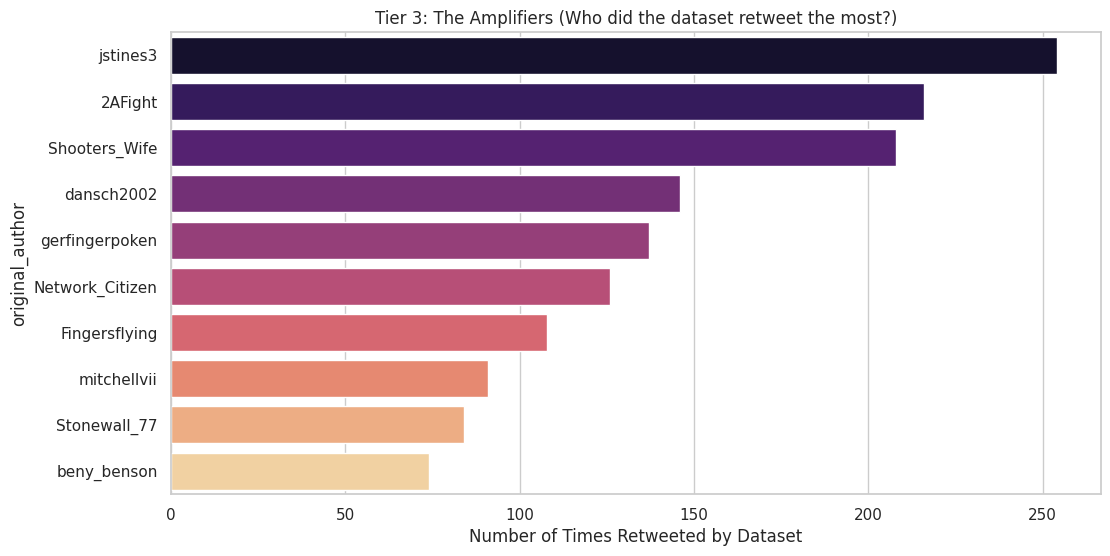

In [48]:
print("--- ACTOR CATEGORY: TIER 3 - THE AMPLIFIERS ---\n")
print("(External accounts most frequently retweeted by the dataset)\n")

# 1. Identify Top 10 most retweeted handles
# We drop N/A values to focus only on actual retweets
top_amplifiers = df['original_author'].value_counts().head(10)

print(top_amplifiers)

# 2. Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=top_amplifiers.values, y=top_amplifiers.index, palette='magma')
plt.title('Tier 3: The Amplifiers (Who did the dataset retweet the most?)')
plt.xlabel('Number of Times Retweeted by Dataset')
plt.show()

--- COMPARATIVE BEHAVIORAL ANALYSIS: WHO LEADS THE TREND? ---



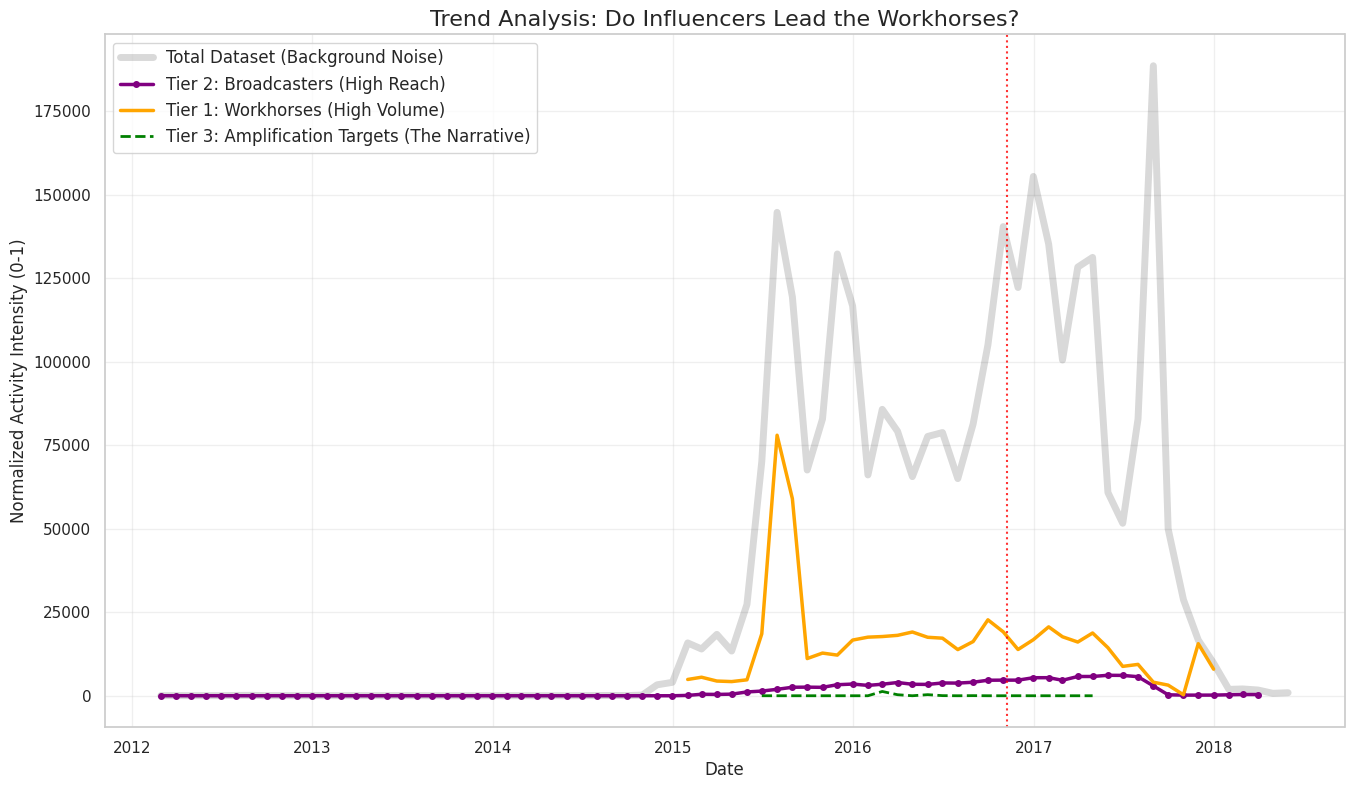

Correlation with Amplified Narrative:
Workhorses:  -0.0779
Broadcasters:-0.0754


In [55]:
print("--- COMPARATIVE BEHAVIORAL ANALYSIS: WHO LEADS THE TREND? ---\n")

# 1. Ensure Data is Ready
df['publish_date'] = pd.to_datetime(df['publish_date'])
if 'original_author' not in df.columns:
    df['original_author'] = df['content'].str.extract(r'RT @(\w+):')

# 2. Define the 3 Distinct Groups (Top 20 of each to get a robust signal)
# Group A: The WORKHORSES (High Volume)
top_workhorses = df['author'].value_counts().head(20).index

# Group B: The BROADCASTERS (High Reach/Followers)
# We take the accounts with the highest max follower count
top_broadcasters = df.groupby('author')['followers'].max().sort_values(ascending=False).head(20).index

# Group C: The AMPLIFIED (The content sources)
# These are the accounts that are Retweeted the most. Tracking them shows when the "narrative" spikes.
top_amplified = df['original_author'].value_counts().head(20).index

# 3. Create Time Series for each group
# Resampling by Month ('ME')
ts_total = df.set_index('publish_date').resample('ME').size()
ts_workhorse = df[df['author'].isin(top_workhorses)].set_index('publish_date').resample('ME').size()
ts_broadcaster = df[df['author'].isin(top_broadcasters)].set_index('publish_date').resample('ME').size()
ts_amplified = df[df['original_author'].isin(top_amplified)].set_index('publish_date').resample('ME').size()


# 5. Plotting the "Lead/Follow" Dynamics
plt.figure(figsize=(16, 9))

# Plot Total (The General Noise)
plt.plot(ts_total.index, ts_total,
         color='black', alpha=0.15, linewidth=5, label='Total Dataset')

# Plot The 3 Tiers
plt.plot(ts_broadcaster.index, ts_broadcaster,
         color='purple', linewidth=2.5, linestyle='-', marker='o', markersize=4, label='Tier 2: Broadcasters')

plt.plot(ts_workhorse.index, ts_workhorse,
         color='orange', linewidth=2.5, linestyle='-', label='Tier 1: Workhorses')

plt.plot(ts_amplified.index, ts_amplified,
         color='green', linewidth=2, linestyle='--', label='Tier 3: Amplification Targets')

plt.title('Trend Analysis: Do Influencers Lead the Workhorses?', fontsize=16)
plt.ylabel('Normalized Activity Intensity (0-1)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Highlight 2016 Election
plt.axvline(pd.to_datetime('2016-11-08'), color='red', linestyle=':', alpha=0.8, label='2016 Election')

plt.show()


--- COMPARATIVE BEHAVIORAL ANALYSIS: WHO LEADS THE TREND? ---



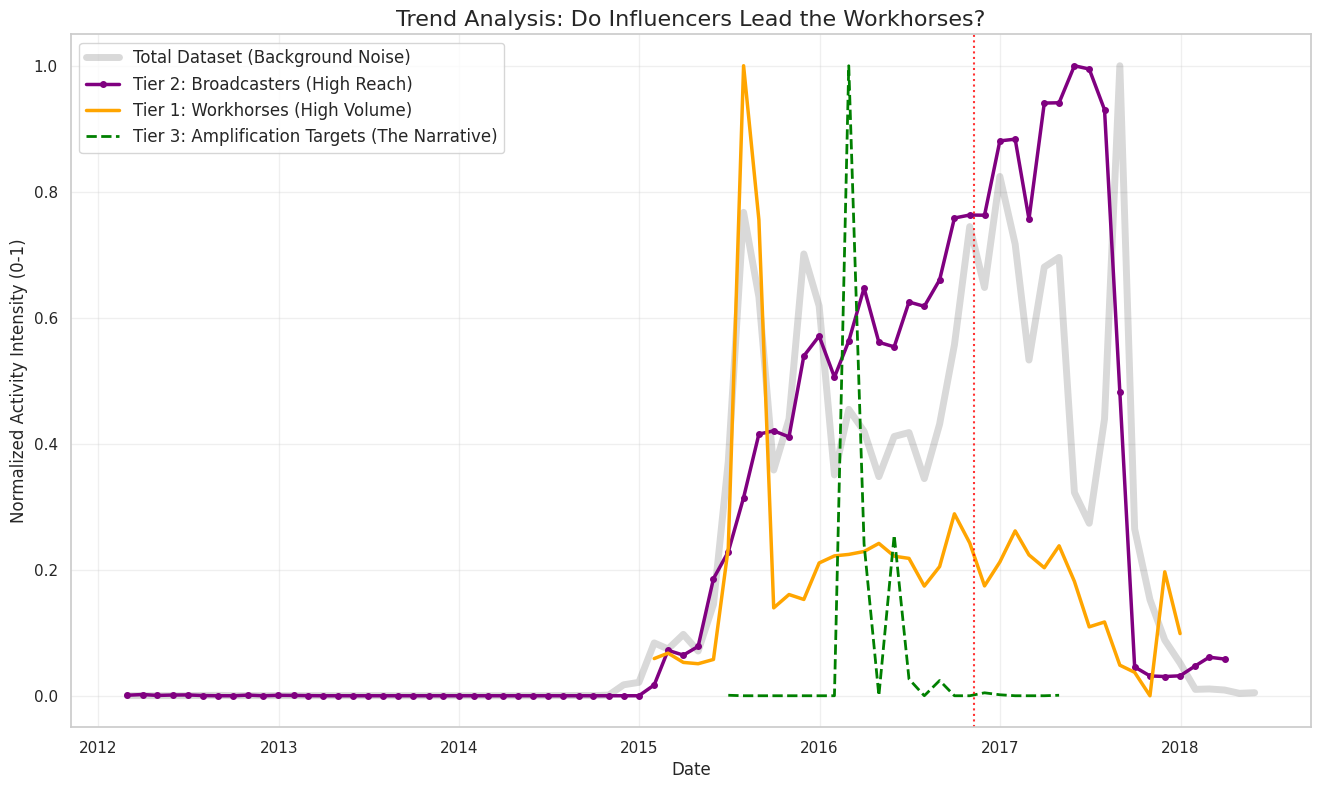

Correlation with Amplified Narrative:
Workhorses:  -0.0779
Broadcasters:-0.0754


In [56]:
print("--- COMPARATIVE BEHAVIORAL ANALYSIS: WHO LEADS THE TREND? ---\n")

# 1. Ensure Data is Ready
df['publish_date'] = pd.to_datetime(df['publish_date'])
if 'original_author' not in df.columns:
    df['original_author'] = df['content'].str.extract(r'RT @(\w+):')

# 2. Define the 3 Distinct Groups (Top 20 of each to get a robust signal)
# Group A: The WORKHORSES (High Volume)
top_workhorses = df['author'].value_counts().head(20).index

# Group B: The BROADCASTERS (High Reach/Followers)
# We take the accounts with the highest max follower count
top_broadcasters = df.groupby('author')['followers'].max().sort_values(ascending=False).head(20).index

# Group C: The AMPLIFIED (The content sources)
# These are the accounts that are Retweeted the most. Tracking them shows when the "narrative" spikes.
top_amplified = df['original_author'].value_counts().head(20).index

# 3. Create Time Series for each group
# Resampling by Month ('ME')
ts_total = df.set_index('publish_date').resample('ME').size()
ts_workhorse = df[df['author'].isin(top_workhorses)].set_index('publish_date').resample('ME').size()
ts_broadcaster = df[df['author'].isin(top_broadcasters)].set_index('publish_date').resample('ME').size()
ts_amplified = df[df['original_author'].isin(top_amplified)].set_index('publish_date').resample('ME').size()

# 4. Normalization Function (Min-Max Scaling)
# This scales everything to 0-1 so we can compare peaks regardless of volume difference
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 5. Plotting the "Lead/Follow" Dynamics
plt.figure(figsize=(16, 9))

# Plot Total (The General Noise)
plt.plot(ts_total.index, normalize(ts_total),
         color='black', alpha=0.15, linewidth=5, label='Total Dataset ')

# Plot The 3 Tiers
plt.plot(ts_broadcaster.index, normalize(ts_broadcaster),
         color='purple', linewidth=2.5, linestyle='-', marker='o', markersize=4, label='Tier 2: Broadcasters')

plt.plot(ts_workhorse.index, normalize(ts_workhorse),
         color='orange', linewidth=2.5, linestyle='-', label='Tier 1: Workhorses')

plt.plot(ts_amplified.index, normalize(ts_amplified),
         color='green', linewidth=2, linestyle='--', label='Tier 3: Amplification Targets')

plt.title('Trend Analysis: Do Influencers Lead the Workhorses?', fontsize=16)
plt.ylabel('Normalized Activity Intensity (0-1)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Highlight 2016 Election
plt.axvline(pd.to_datetime('2016-11-08'), color='red', linestyle=':', alpha=0.8, label='2016 Election')

plt.show()


In [8]:
print("--- STAGE 2: CREATING FOCUSED SUBSET ---\n")

# 1. Define filter criteria
target_categories = ['LeftTroll', 'RightTroll']
target_language = 'English'

# 2. Create the subset
# Filter first to optimize performance
df_subset = df[
    (df['language'] == target_language) &
    (df['account_category'].isin(target_categories))
].copy()

# 3. Feature Engineering (Creating the columns you requested)
# Extract original author from Retweets
df_subset['original_author'] = df_subset['content'].str.extract(r'RT @(\w+):')
# Extract mentions
df_subset['mentions'] = df_subset['content'].apply(lambda x: re.findall(r'@(\w+)', str(x)))
# Ensure publish_date is datetime
df_subset['publish_date'] = pd.to_datetime(df_subset['publish_date'])

# 4. Select specific columns
columns_to_keep = [
    'tweet_id',
    'author',
    'content',
    'publish_date',
    'language',
    'followers',
    'following',
    'updates',
    'post_type',
    'retweet',
    'account_category',
    'original_author',
    'mentions'
]

# Keep only existing columns from the list
existing_cols = [c for c in columns_to_keep if c in df_subset.columns]
df_subset = df_subset[existing_cols]

# 5. Inspection
print(f"Original Dataset Size: {len(df)}")
print(f"Subset Size (English + Left/Right Trolls): {len(df_subset)}")
print(f"Data retained: {len(df_subset)/len(df)*100:.2f}%")
print("\nClass Balance in Subset:")
print(df_subset['account_category'].value_counts())

--- STAGE 2: CREATING FOCUSED SUBSET ---

Original Dataset Size: 2946207
Subset Size (English + Left/Right Trolls): 1127094
Data retained: 38.26%

Class Balance in Subset:
account_category
RightTroll    704953
LeftTroll     422141
Name: count, dtype: int64


In [16]:
print("--- SUBSET ANALYSIS: TEMPORAL PATTERNS ---\n")

import plotly.express as px

# Set index
time_subset = df_subset.set_index('publish_date').sort_index()

# Resample by Month and Account Category to compare activity
# We use unstack() to create columns for LeftTroll and RightTroll
monthly_comparison = time_subset.groupby([pd.Grouper(freq='ME'), 'account_category']).size().unstack()

# Plotting using Plotly for interactivity
fig = px.line(monthly_comparison, x=monthly_comparison.index, y=monthly_comparison.columns,
              title='Monthly Tweet Volume: Left Trolls vs. Right Trolls',
              labels={'value':'Number of Tweets', 'publish_date':'Date', 'variable':'Account Category'})

# Add Reference Lines for 2016 Election (Plotly equivalent)
# Removing annotation_text and annotation_position to bypass TypeError, as the line itself is the primary goal and hover provides details.
fig.add_vline(x=pd.to_datetime('2016-11-08').isoformat(), line_dash="dash", line_color="red")

fig.update_layout(hovermode="x unified") # Unified hover for better comparison
fig.show()

--- SUBSET ANALYSIS: TEMPORAL PATTERNS ---



In [19]:
print("--- SUBSET ANALYSIS: TEMPORAL PATTERNS ---\n")

import plotly.express as px

# Set index
time_subset = df_subset.set_index('publish_date').sort_index()

# Resample by Day and Account Category to compare activity
# We use unstack() to create columns for LeftTroll and RightTroll
monthly_comparison = time_subset.groupby([pd.Grouper(freq='D'), 'account_category']).size().unstack()

# Calculate max y-value for padding the y-axis range
max_y_value = monthly_comparison.max().max() if not monthly_comparison.empty else 0
y_axis_upper_bound = max_y_value * 1.05 # Add 5% padding

# Plotting using Plotly for interactivity
fig = px.line(monthly_comparison, x=monthly_comparison.index, y=monthly_comparison.columns,
              title='Daily Tweet Volume: Left Trolls vs. Right Trolls', # Changed title for 'D' freq
              labels={'value':'Number of Tweets', 'publish_date':'Date', 'variable':'Account Category'})

# Add Reference Lines for 2016 Election (Plotly equivalent)
# Removing annotation_text and annotation_position to bypass TypeError, as the line itself is the primary goal and hover provides details.
fig.add_vline(x=pd.to_datetime('2016-11-08').isoformat(), line_dash="dash", line_color="red")

fig.update_layout(hovermode="x unified", yaxis_range=[0, y_axis_upper_bound]) # Add yaxis_range to ensure full visibility
fig.show()

--- SUBSET ANALYSIS: TEMPORAL PATTERNS ---



--- SUBSET ANALYSIS: TOP WORDS DURING PEAK PERIODS ---

Right Troll peak records: 74899
Left Troll peak records: 13158

Analyzing Left Troll vocabulary (peak day)...
Analyzing Right Troll vocabulary (peak period)...


/tmp/ipython-input-3657514231.py:78: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-3657514231.py:82: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




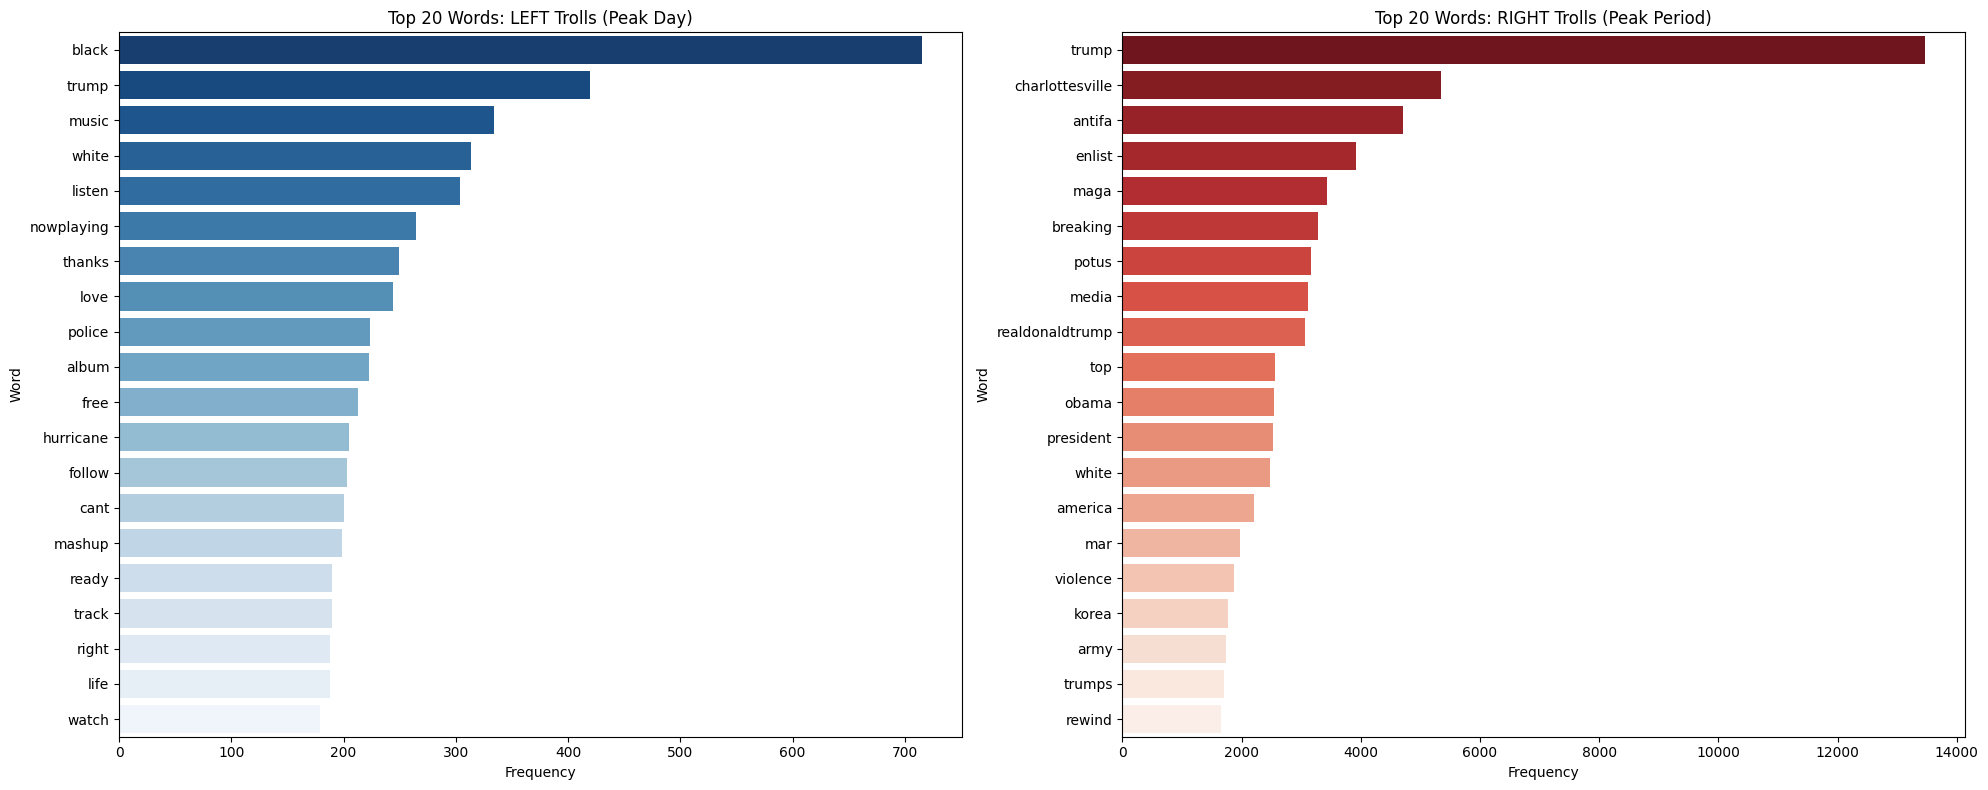

In [27]:
print("--- SUBSET ANALYSIS: TOP WORDS DURING PEAK PERIODS ---\n")

# -------------------------------------------------------------
# 1. Setup Stopwords
# -------------------------------------------------------------
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

custom_ignore_list = [
    'https', 'http', 'rt', 'co', 'amp', 'bit', 'ly', 'via', 'ifttt',
    'just', 'like', 'will', 'one', 'get', 'new', 'people', 'time',
    'would', 'make', 'video', 'know', 'say', 'see', 'can', 'got',
    'want', 'back', 'good', 'day', 'year', 'think', 'need', 'look',
    'man', 'woman', 'us', 'go', 'much', 'thing', 'really', 'today',
    'twitter', 'com', 'pic', 'status', 'web', 'instagram', 'fb', 'dont'
]

stop_words.update(custom_ignore_list)

# -------------------------------------------------------------
# 2. Helper Function
# -------------------------------------------------------------
def get_top_words(text_series, n=20):
    all_words = []
    for text in text_series.dropna().tolist():
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
        words = [w for w in text.split() if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['Word', 'Count'])

# -------------------------------------------------------------
# 3. Filter by Peak Windows
# -------------------------------------------------------------
# Ensure datetime index or convert
df_subset['publish_date'] = pd.to_datetime(df_subset['publish_date'])

# Right Troll Peak: 2017-08-11 to 2017-08-18
right_peak = df_subset[
    (df_subset['account_category'] == 'RightTroll') &
    (df_subset['publish_date'] >= '2017-08-11') &
    (df_subset['publish_date'] <= '2017-08-18')
]

# Left Troll Peak: 2016-10-06 (feel free to extend +-1 day)
left_peak = df_subset[
    (df_subset['account_category'] == 'LeftTroll') &
    (df_subset['publish_date'] >= '2016-10-5') &
    (df_subset['publish_date'] <= '2016-10-7')
]

print(f"Right Troll peak records: {len(right_peak)}")
print(f"Left Troll peak records: {len(left_peak)}\n")

# -------------------------------------------------------------
# 4. Generate Top Words
# -------------------------------------------------------------
print("Analyzing Left Troll vocabulary (peak day)...")
left_words_df = get_top_words(left_peak['content'])

print("Analyzing Right Troll vocabulary (peak period)...")
right_words_df = get_top_words(right_peak['content'])

# -------------------------------------------------------------
# 5. Visualize Side-by-Side
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(data=left_words_df, x='Count', y='Word', ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 20 Words: LEFT Trolls (Peak Day)')
axes[0].set_xlabel('Frequency')

sns.barplot(data=right_words_df, x='Count', y='Word', ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 20 Words: RIGHT Trolls (Peak Period)')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()


In [13]:
print("--- FINDING PEAK DAY FOR RIGHT WING TWEETS ---\n")

# Filter for Right Trolls
right_troll_tweets = df_subset[df_subset['account_category'] == 'RightTroll'].copy()

# Extract just the date from publish_date
right_troll_tweets['publish_date_only'] = right_troll_tweets['publish_date'].dt.date

# Count tweets per day
daily_tweet_counts = right_troll_tweets['publish_date_only'].value_counts()

# Find the day with the maximum number of tweets
peak_day = daily_tweet_counts.idxmax()
peak_count = daily_tweet_counts.max()

print(f"The day with the most right-wing tweets was: {peak_day} with {peak_count} tweets.")

--- FINDING PEAK DAY FOR RIGHT WING TWEETS ---

The day with the most right-wing tweets was: 2017-08-15 with 12223 tweets.


--- SUBSET ANALYSIS: HASHTAG NARRATIVES ---



/tmp/ipython-input-435513804.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=left_tags.values, y=left_tags.index, ax=ax[0], palette='Blues_r')
/tmp/ipython-input-435513804.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=right_tags.values, y=right_tags.index, ax=ax[1], palette='Reds_r')


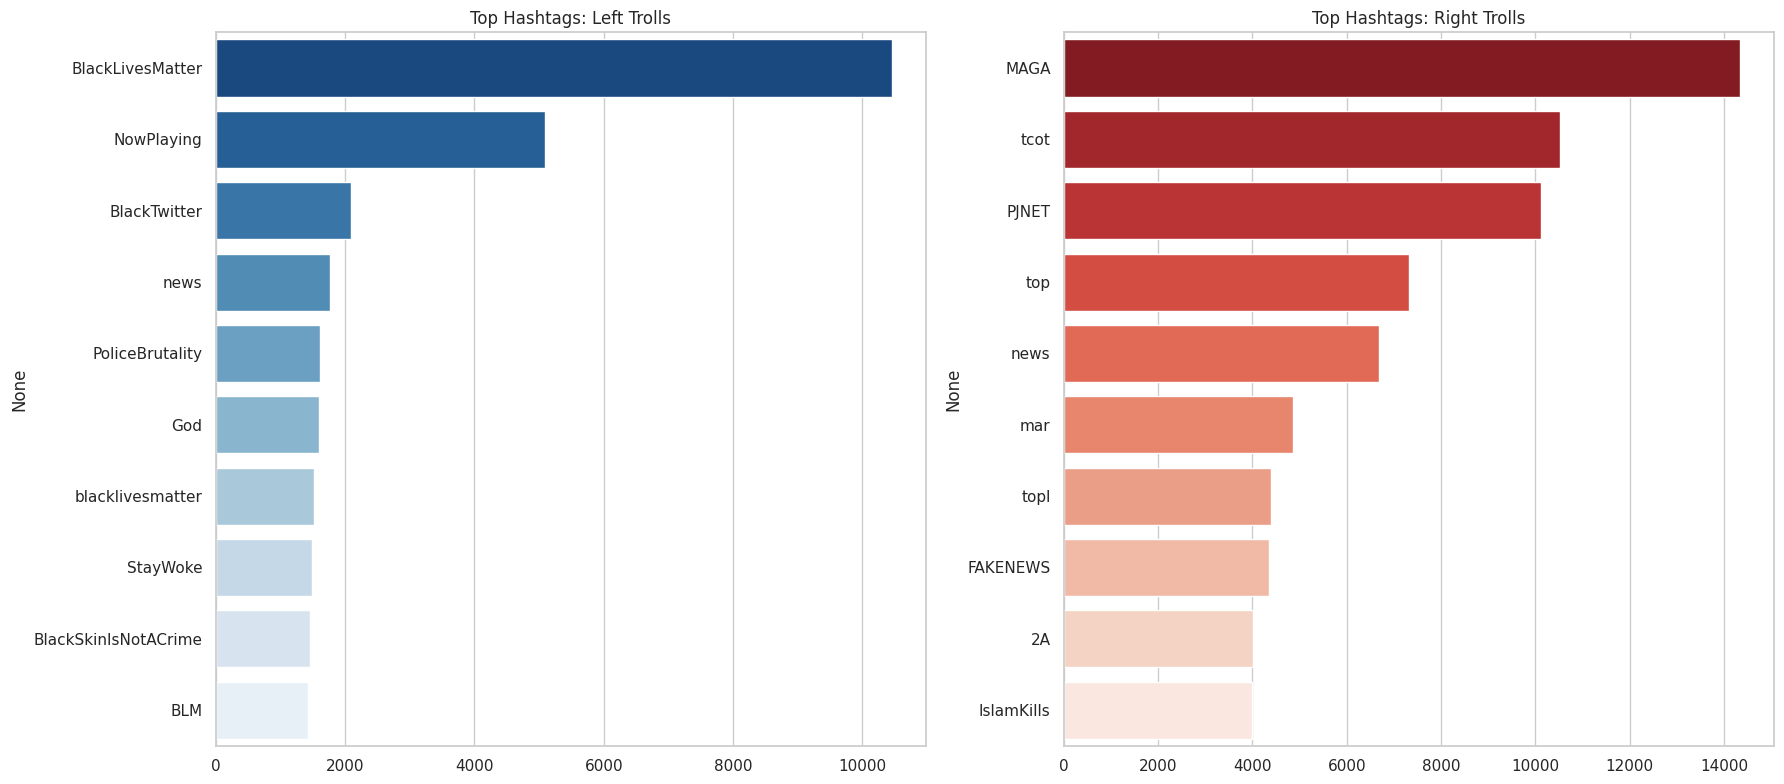

In [39]:
print("--- SUBSET ANALYSIS: HASHTAG NARRATIVES ---\n")

# Function to get top hashtags for a specific dataframe
def get_top_tags(data, n=10):
    text_blob = " ".join(data.dropna().astype(str))
    tags = re.findall(r"#(\w+)", text_blob)
    return pd.Series(Counter(tags)).sort_values(ascending=False).head(n)

# Get top tags for Left and Right separately
left_tags = get_top_tags(df_subset[df_subset['account_category'] == 'LeftTroll']['content'])
right_tags = get_top_tags(df_subset[df_subset['account_category'] == 'RightTroll']['content'])

# Plotting side-by-side
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(x=left_tags.values, y=left_tags.index, ax=ax[0], palette='Blues_r')
ax[0].set_title('Top Hashtags: Left Trolls')

sns.barplot(x=right_tags.values, y=right_tags.index, ax=ax[1], palette='Reds_r')
ax[1].set_title('Top Hashtags: Right Trolls')

plt.tight_layout()
plt.show()

--- SUBSET ANALYSIS: TOP WORDS BY IDEOLOGY ---

Analyzing Left Troll vocabulary...
Analyzing Right Troll vocabulary...


/tmp/ipython-input-3264564471.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=left_words_df, x='Count', y='Word', ax=axes[0], palette='Blues_r')
/tmp/ipython-input-3264564471.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=right_words_df, x='Count', y='Word', ax=axes[1], palette='Reds_r')


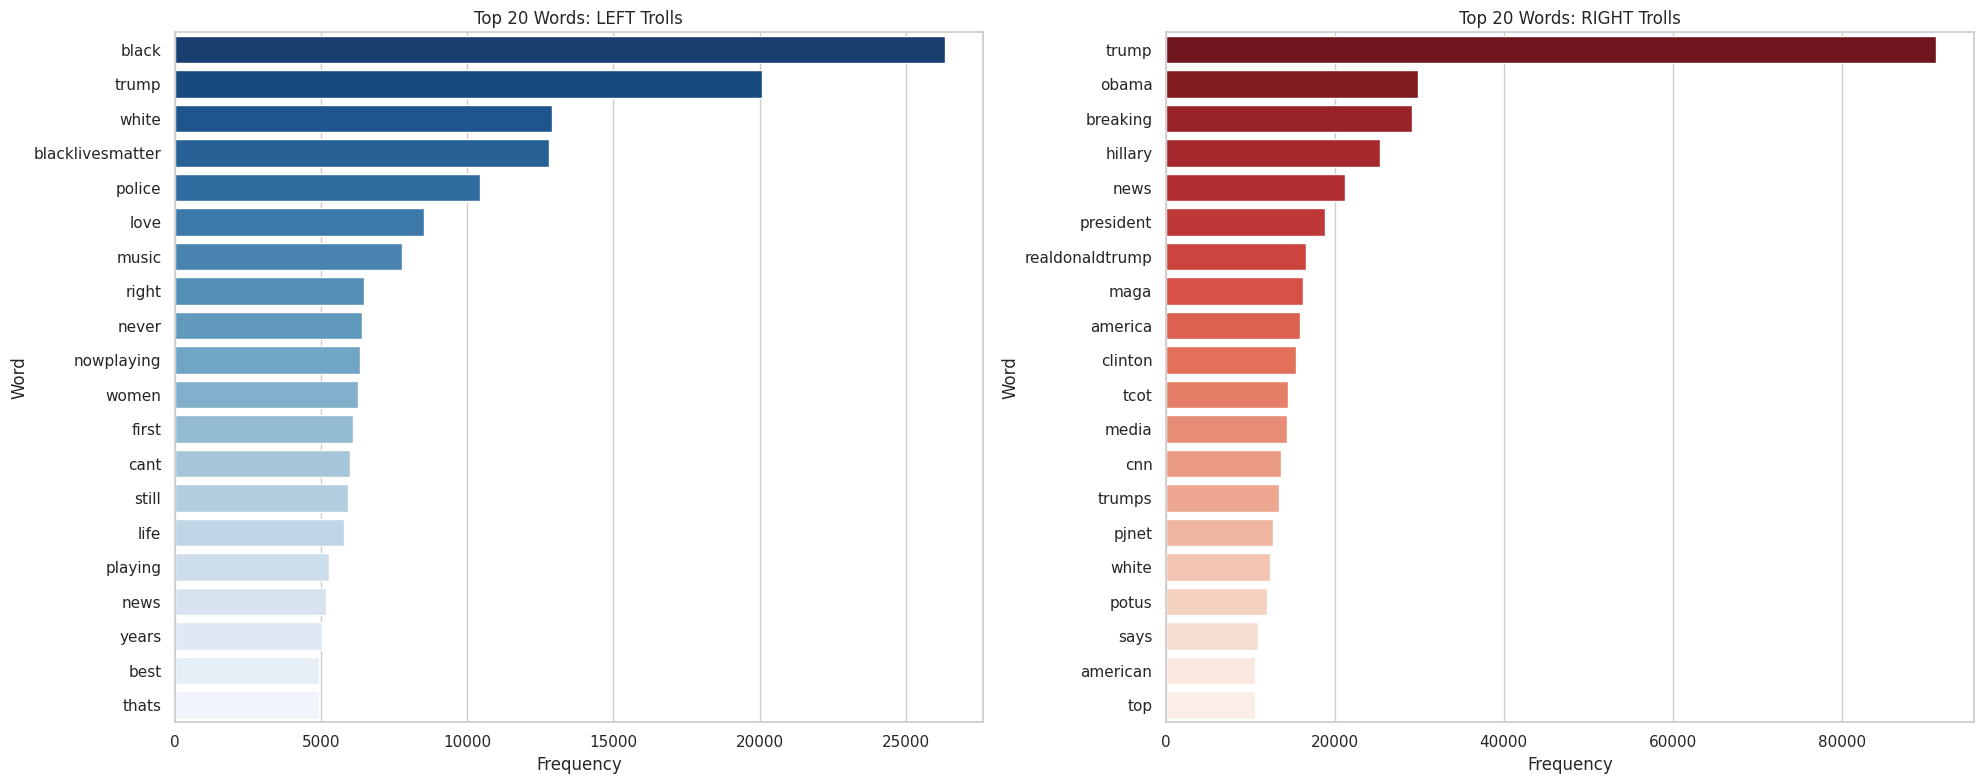

In [59]:
print("--- SUBSET ANALYSIS: TOP WORDS BY IDEOLOGY ---\n")

# 1. Setup Stopwords
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
custom_ignore_list = [
    'https', 'http', 'rt', 'co', 'amp', 'bit', 'ly', 'via', 'ifttt',
    'just', 'like', 'will', 'one', 'get', 'new', 'people', 'time',
    'would', 'make', 'video', 'know', 'say', 'see', 'can', 'got',
    'want', 'back', 'good', 'day', 'year', 'think', 'need', 'look',
    'man', 'woman', 'us', 'go', 'much', 'thing', 'really', 'today',
    'twitter', 'com', 'pic', 'status', 'web', 'instagram', 'fb','dont'
]
# Add common tweet-specific noise to stopwords
stop_words.update(custom_ignore_list)

# 2. Define Helper Function to Clean and Count
def get_top_words(text_series, n=20):
    all_words = []
    # Convert to list for faster processing than iterating series
    for text in text_series.dropna().tolist():
        # Lowercase
        text = str(text).lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation/numbers (keep only letters)
        text = re.sub(r'[^a-z\s]', '', text)

        # Tokenize and filter
        # Words must be > 2 chars and not in stop_words
        words = [w for w in text.split() if w not in stop_words and len(w) > 2]
        all_words.extend(words)

    return pd.DataFrame(Counter(all_words).most_common(n), columns=['Word', 'Count'])

# 3. Process the Data
print("Analyzing Left Troll vocabulary...")
left_words_df = get_top_words(df_subset[df_subset['account_category'] == 'LeftTroll']['content'])

print("Analyzing Right Troll vocabulary...")
right_words_df = get_top_words(df_subset[df_subset['account_category'] == 'RightTroll']['content'])

# 4. Visualize Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left Trolls Plot
sns.barplot(data=left_words_df, x='Count', y='Word', ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 20 Words: LEFT Trolls')
axes[0].set_xlabel('Frequency')

# Right Trolls Plot
sns.barplot(data=right_words_df, x='Count', y='Word', ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 20 Words: RIGHT Trolls')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

--- COMPARATIVE TREND ANALYSIS: LEFT vs. RIGHT (Dual-Axis) ---



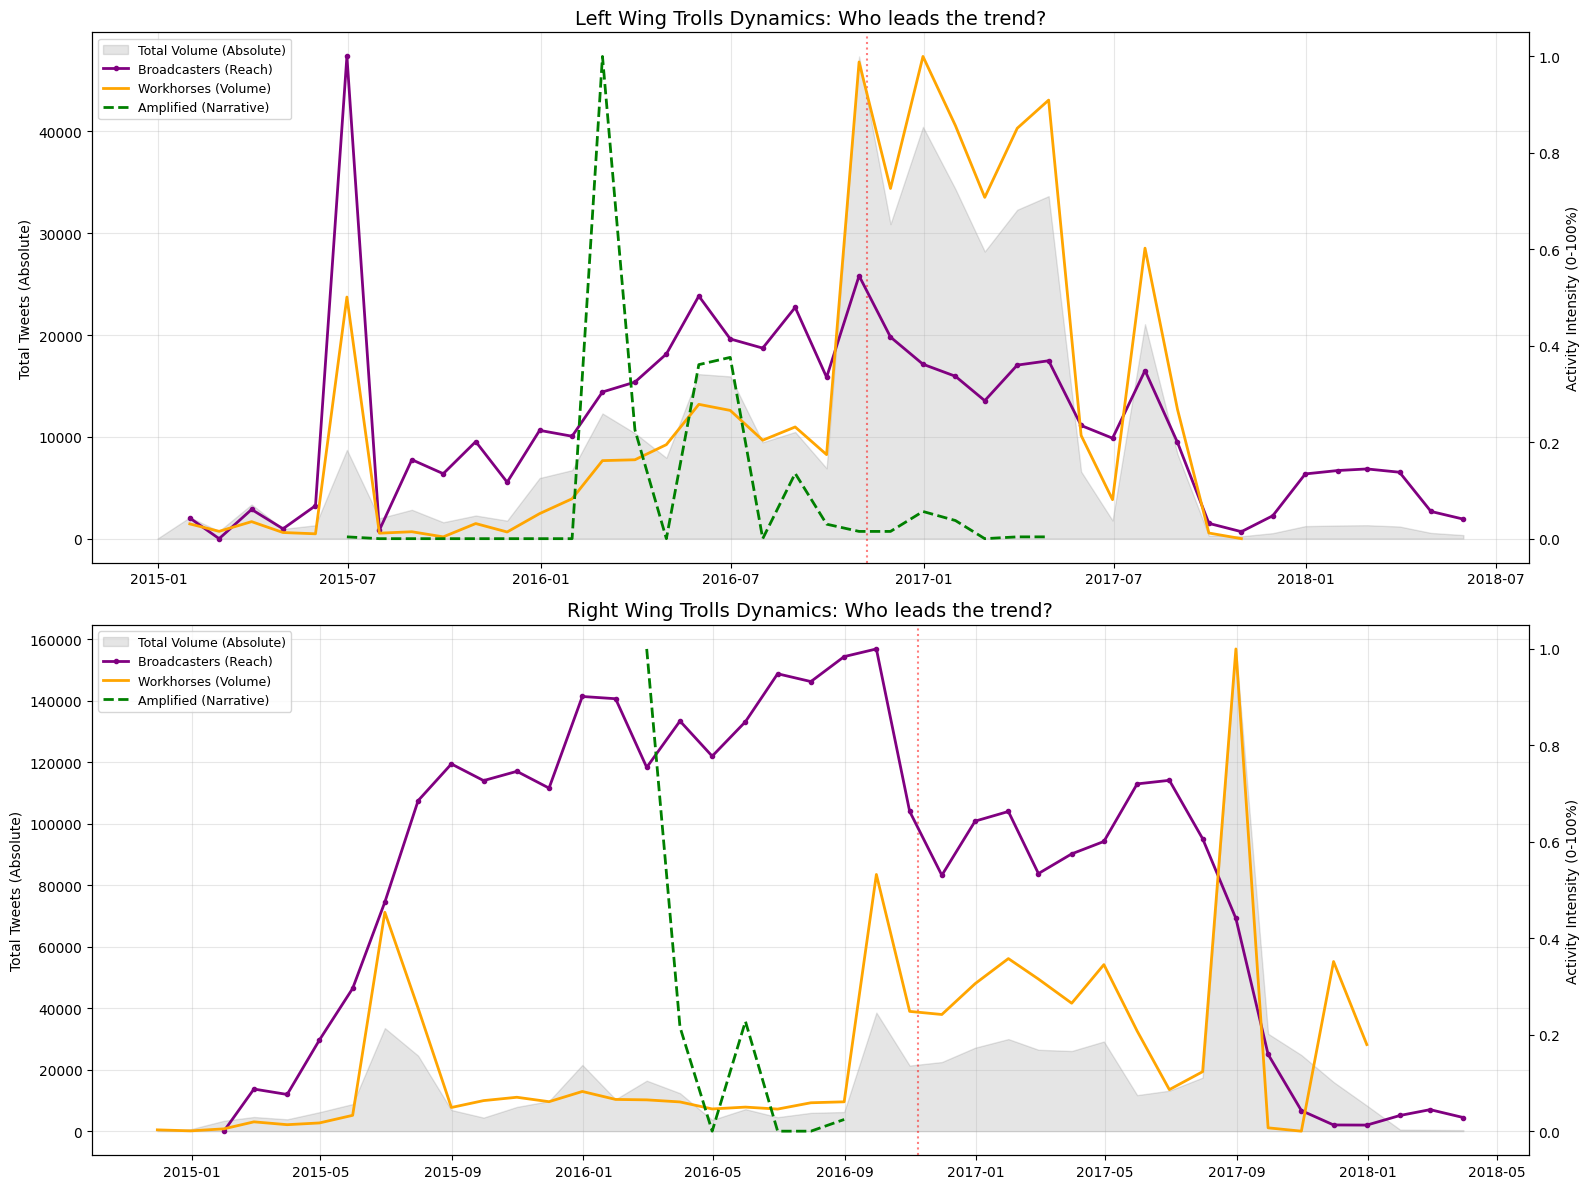

In [12]:
print("--- COMPARATIVE TREND ANALYSIS: LEFT vs. RIGHT (Dual-Axis) ---\n")

# 1. Data Prep (Same as before)
target_categories = ['LeftTroll', 'RightTroll']
df_subset = df[
    (df['language'] == 'English') &
    (df['account_category'].isin(target_categories))
].copy()

df_subset['publish_date'] = pd.to_datetime(df_subset['publish_date'])
df_subset['original_author'] = df_subset['content'].str.extract(r'RT @(\w+):')

# Determine the earliest publish date for Right Trolls to synchronize both plots
right_troll_min_date = df_subset[df_subset['account_category'] == 'RightTroll']['publish_date'].min()

# Filter the entire subset to start from this date
df_subset = df_subset[df_subset['publish_date'] >= right_troll_min_date].copy()

# Normalization Function
def normalize(series):
    if series.max() == series.min(): return series
    return (series - series.min()) / (series.max() - series.min())

# 2. Analysis Function (Dual Axis)
def plot_dual_axis_trend(data, category_name, ax1):
    # A. Identify Groups for this specific category
    top_workhorses = data['author'].value_counts().head(20).index
    top_broadcasters = data.groupby('author')['followers'].max().sort_values(ascending=False).head(20).index
    top_amplified = data['original_author'].value_counts().head(20).index

    # B. Create Time Series
    ts_total = data.set_index('publish_date').resample('ME').size()
    ts_workhorse = data[data['author'].isin(top_workhorses)].set_index('publish_date').resample('ME').size()
    ts_broadcaster = data[data['author'].isin(top_broadcasters)].set_index('publish_date').resample('ME').size()
    ts_amplified = data[data['original_author'].isin(top_amplified)].set_index('publish_date').resample('ME').size()

    # C. Plot Primary Axis (Background Volume)
    ax1.fill_between(ts_total.index, ts_total.values, color='black', alpha=0.1, label='Total Volume (Absolute)')
    ax1.set_ylabel('Total Tweets (Absolute)', color='black', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='black')

    # D. Plot Secondary Axis (Normalized Trends)
    ax2 = ax1.twinx()
    ax2.plot(ts_broadcaster.index, normalize(ts_broadcaster),
             color='purple', linewidth=2, marker='o', markersize=3, label='Broadcasters (Reach)')

    ax2.plot(ts_workhorse.index, normalize(ts_workhorse),
             color='orange', linewidth=2, label='Workhorses (Volume)')

    ax2.plot(ts_amplified.index, normalize(ts_amplified),
             color='green', linewidth=2, linestyle='--', label='Amplified (Narrative)')

    ax2.set_ylabel('Activity Intensity (0-100%)', color='black', fontsize=10)

    # Aesthetics
    ax1.set_title(f'{category_name} Dynamics: Who leads the trend?', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Election Marker
    ax1.axvline(pd.to_datetime('2016-11-08'), color='red', linestyle=':', alpha=0.5)

    # Legend (Combine both axes)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

# 3. Execution
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Left Trolls
left_data = df_subset[df_subset['account_category'] == 'LeftTroll']
plot_dual_axis_trend(left_data, "Left Wing Trolls", axes[0])

# Right Trolls
right_data = df_subset[df_subset['account_category'] == 'RightTroll']
plot_dual_axis_trend(right_data, "Right Wing Trolls", axes[1])

plt.tight_layout()
plt.show()

In [22]:
import plotly.express as px
import pandas as pd

print("--- RETWEET ANALYSIS: VOLUME OVER TIME BY BOT TYPE ---\n")

# Ensure df_subset is available and has 'retweet' column
# If df_subset is not defined, run the earlier cells that create it.
# (Assuming df_subset and its 'retweet' and 'account_category' columns are ready from previous steps)

# 1. Filter for actual retweets
# The 'retweet' column typically indicates if a tweet is a retweet (1 for retweet, 0 otherwise)
retweets_df = df_subset[df_subset['retweet'] == 1].copy()

# 2. Prepare data for temporal analysis
# Set index to publish_date and resample monthly
time_retweets = retweets_df.set_index('publish_date').sort_index()

# Group by month and account_category, then count retweets
monthly_retweets_comparison = time_retweets.groupby([
    pd.Grouper(freq='ME'), 'account_category'
]).size().unstack(fill_value=0) # fill_value=0 for months with no activity

# Calculate max y-value for padding the y-axis range
max_y_value_retweets = monthly_retweets_comparison.max().max() if not monthly_retweets_comparison.empty else 0
y_axis_upper_bound_retweets = max_y_value_retweets * 1.05 # Add 5% padding

# 3. Plotting using Plotly for interactivity
fig = px.line(monthly_retweets_comparison, x=monthly_retweets_comparison.index, y=monthly_retweets_comparison.columns,
              title='Monthly Retweet Volume: Left Trolls vs. Right Trolls',
              labels={'value':'Number of Retweets', 'publish_date':'Date', 'variable':'Account Category'})

# Add Reference Line for 2016 Election
fig.add_vline(x=pd.to_datetime('2016-11-08').isoformat(), line_dash="dash", line_color="red")

fig.update_layout(hovermode="x unified", yaxis_range=[0, y_axis_upper_bound_retweets])
fig.show()

# 4. Print total number of retweets by bot type
print("\n--- TOTAL RETWEETS BY BOT TYPE ---")
total_retweets_by_category = retweets_df['account_category'].value_counts()
print(total_retweets_by_category)

--- RETWEET ANALYSIS: VOLUME OVER TIME BY BOT TYPE ---




--- TOTAL RETWEETS BY BOT TYPE ---
account_category
LeftTroll     345724
RightTroll    305103
Name: count, dtype: int64


### RETWEET ANALYSIS: Bots Retweeting External/Potentially Human Accounts

This section filters retweets to focus only on instances where the `original_author` (the account being retweeted) is **not** one of the known troll accounts within our `df_subset` (which contains both LeftTroll and RightTroll authors). This provides a proxy for understanding when bots amplified external voices, which we'll refer to as 'real people' for simplicity, recognizing the limitations of this heuristic.

In [24]:
print("--- RETWEET ANALYSIS: Bots Retweeting External Accounts ---\n")

# Ensure df_subset is available and has 'retweet' and 'original_author' columns
# (Assuming these are ready from previous steps)

# 1. Get a comprehensive list of all known troll authors from the *full* dataset (df)
# This ensures we don't accidentally count retweets of other trolls (e.g., non-English ones)
# as 'real people' just because they weren't in our specific df_subset.
known_troll_authors = df['author'].unique()

# 2. Filter for actual retweets made by our bots
retweets_df = df_subset[df_subset['retweet'] == 1].copy()

# 3. Further filter to include only retweets where the original_author is NOT a known troll
# This means the bot retweeted an account that is not one of our identified trolls (from the entire dataset).
# We consider these 'external' or 'potentially human' accounts for this analysis.
real_person_retweets_df = retweets_df[~retweets_df['original_author'].isin(known_troll_authors)].copy()

# 4. Prepare data for temporal analysis
time_real_person_retweets = real_person_retweets_df.set_index('publish_date').sort_index()

# Group by month and account_category, then count retweets
monthly_real_person_retweets_comparison = time_real_person_retweets.groupby([
    pd.Grouper(freq='ME'), 'account_category'
]).size().unstack(fill_value=0)

# Calculate max y-value for padding the y-axis range
max_y_value_real_retweets = monthly_real_person_retweets_comparison.max().max() if not monthly_real_person_retweets_comparison.empty else 0
y_axis_upper_bound_real_retweets = max_y_value_real_retweets * 1.05 # Add 5% padding

# 5. Plotting using Plotly for interactivity
fig_real = px.line(monthly_real_person_retweets_comparison, x=monthly_real_person_retweets_comparison.index, y=monthly_real_person_retweets_comparison.columns,
              title='Monthly Retweet Volume: Bots Amplifying External/Human Accounts',
              labels={'value':'Number of Retweets', 'publish_date':'Date', 'variable':'Bot Account Category'})

# Add Reference Line for 2016 Election
fig_real.add_vline(x=pd.to_datetime('2016-11-08').isoformat(), line_dash="dash", line_color="red")

fig_real.update_layout(hovermode="x unified", yaxis_range=[0, y_axis_upper_bound_real_retweets])
fig_real.show()

# 6. Print total number of real person retweets by bot type
print("\n--- TOTAL RETWEETS OF EXTERNAL/HUMAN ACCOUNTS BY BOT TYPE ---")
total_real_person_retweets_by_category = real_person_retweets_df['account_category'].value_counts()
print(total_real_person_retweets_by_category)

--- RETWEET ANALYSIS: Bots Retweeting External Accounts ---




--- TOTAL RETWEETS OF EXTERNAL/HUMAN ACCOUNTS BY BOT TYPE ---
account_category
LeftTroll     345724
RightTroll    305103
Name: count, dtype: int64
